# Multiscale Analysis of Production of 1,3PDO and 3HP from Biomass
## Stage 2. Bioreactor Scale Simulations

In [6]:
%reset -f
%load_ext autoreload
%autoreload 2
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


## 2.0 Setting Up
- Two *in silico* Organisms (*E. coli* and *S. cerevisiae*) are created based on the "super-models" that contains the predicted pathways for 1,3PDO and 3HP production
- A collection of six *in silico* Bioreactors are created.
    - 3 different growth environments:  glucose/aerobic, glucose/anaerobic, glycerol/aerobic
        - glycerol/anaerobic is not used because it was determined in Stage 1 that the yield and growth rates is too low
    - 2 different products

In [2]:
### Setting up in silico Organisms
import cPickle as pickle
from cbmTES.global_constants import *
from cbmTES.bioreactor import Ecoli, Scerevisiae

## Setting up E. coli
ecoli_model = pickle.load(open('models/ecoli_super.pickle','rb'))

# maximum titer of products are set to 100 g/L for E. coli
titer_limit = {}
titer_limit[r_13PDO] = 100.0/76*1000
titer_limit[r_3HPP] = 100.0/90*1000

ecoli = Ecoli(ecoli_model, id='ecoli', titer_limit=titer_limit)

## Setting up S. cerevisiae 
scere_model = pickle.load(open('models/scere_super.pickle','rb'))

# maximum titer of products are set to 150 g/L for S. cerevisiae
titer_limit = {}
titer_limit[r_13PDO] = 150.0/76*1000
titer_limit[r_3HPP] = 150.0/90*1000


scere = Scerevisiae(scere_model, id='scere', titer_limit=titer_limit)

Biomass reaction detected: R_Ec_biomass_iJO1366_core_53p95M
Biomass reaction detected: R_biomass_SC5_notrace


In [3]:
### Setting up a collection of in silico Bioreactors
from cbmTES.bioreactor import IdealFedbatch
from cbmTES.bioreactor import ecoli_parameters, scere_parameters

hosts = [ecoli, scere]
#hosts = [scere]
oxygen_availability = [AEROBIC, ANAEROBIC]
substrates = [r_glc, r_glyc]
product = [r_13PDO, r_3HPP]

# construct a bioreactor instance for each condition.
bioreactors = OrderedDict()

# host specific parameters
s_feed = {}
s_init = {}

s_feed[ecoli.id, r_glc] = 500.0/180*1000 #Alves 2007
s_init[ecoli.id, r_glc] = 50.0/180*1000
s_feed[ecoli.id, r_glyc] = 500.0/92*1000
s_init[ecoli.id, r_glyc] = 100.0/92*1000
s_feed[scere.id, r_glc] = 500.0/180*1000
s_init[scere.id, r_glc] = 200.0/180*1000
s_feed[scere.id, r_glyc] = 500.0/92*1000
s_init[scere.id, r_glyc] = 60.0/92*1000



conditions = [(h, o, s, p) for h in hosts for o in oxygen_availability for s in substrates for p in product if not (o == ANAEROBIC and s == r_glyc) ]

for condition in conditions:
    host = condition[0]
    oxygen_availability = condition[1]
    substrate = condition[2]
    product = condition[3]
    
    metabolites = [substrate, product]
    Sfeed = [s_feed[host.id, substrate], 0]
    bioreactors[host.id, oxygen_availability, substrate, product] = IdealFedbatch(metabolites=metabolites, Sfeed = Sfeed, volume_max=10, oxygen_availability=oxygen_availability)

    # initilize bioreactor
    Vinit = [1]
    Xinit = [0.01]
    Sinit = [s_init[host.id, substrate], 0]
    bioreactors[host.id,  oxygen_availability, substrate, product].set_initial_conditions(Vinit, Xinit, Sinit)
                

## 2.1 Dynamic Scanning Analysis of Production Envelopes
- for each organism (*E. coli* and *S. cerevisie*), six cases were explored:
    - 2 products: 13PDO, 3HP
    - 2 substrates: glucose, glycerol
    - 2 growth conditions: aerobic, anaerobic
    
- the production envelope is constructed for each of cases
- 10 strains are picked along the production envelope (equal distance from each other along the x-axis)
- the dynamics of growth and production is simulated using dFBA
- titer and productivity are calculated from dFBA simulations


In [4]:
from collections import OrderedDict
from time import time
import framed.bioreactor.dyssco as dyssco
import cPickle as pickle

# make 10 strains along production envelopes for each case
strains = OrderedDict()

for condition in conditions:
    host = condition[0]
    oxygen_availability = condition[1]
    substrate = condition[2]
    product = condition[3]
    print host.id, ':', oxygen_availability, ':', substrate, ':', product
    t0 = time()
    strains[host.id, oxygen_availability, substrate, product] = dyssco.make_envelope_strains(host, substrate, product, N=10, constraints=fba_constraints[host.id, substrate, oxygen_availability])
    t1 = time()
    print 'Simulation runtime: ', t1-t0
    
pickle.dump(strains,  open('jar/strains.pickle','wb'))

ecoli : 1 : R_EX_glc_e : R_EX_13PDO_e
Biomass reaction detected: R_Ec_biomass_iJO1366_core_53p95M
Simulation runtime:  14.5949420929
ecoli : 1 : R_EX_glc_e : R_EX_3HPP_e
Simulation runtime:  16.4203460217
ecoli : 1 : R_EX_glyc_e : R_EX_13PDO_e
Simulation runtime:  15.9765679836
ecoli : 1 : R_EX_glyc_e : R_EX_3HPP_e
Simulation runtime:  15.9721269608
ecoli : 0 : R_EX_glc_e : R_EX_13PDO_e
Simulation runtime:  14.6155898571
ecoli : 0 : R_EX_glc_e : R_EX_3HPP_e
Simulation runtime:  15.3559360504
scere : 1 : R_EX_glc_e : R_EX_13PDO_e
Biomass reaction detected: R_biomass_SC5_notrace
Simulation runtime:  8.42463779449
scere : 1 : R_EX_glc_e : R_EX_3HPP_e
Simulation runtime:  8.57913899422
scere : 1 : R_EX_glyc_e : R_EX_13PDO_e
Simulation runtime:  9.03771781921
scere : 1 : R_EX_glyc_e : R_EX_3HPP_e
Simulation runtime:  9.92045092583
scere : 0 : R_EX_glc_e : R_EX_13PDO_e
Simulation runtime:  9.91345095634
scere : 0 : R_EX_glc_e : R_EX_3HPP_e
Simulation runtime:  10.9657211304


In [5]:
# simulate the metabolic activities of these strains using dynamic FBA
from collections import OrderedDict
from time import time
import framed.bioreactor.dyssco as dyssco
import cPickle as pickle

strains = pickle.load(open('jar/strains.pickle', 'rb'))

performances = OrderedDict()

dfba_solutions = {}

for condition in conditions:
    host = condition[0]
    oxygen_availability = condition[1]
    substrate = condition[2]
    product = condition[3]
    bioreactor=bioreactors[host.id, oxygen_availability, substrate, product]
    print host.id, ':', oxygen_availability, ':', substrate, ':', product
    t0 = time()
    strains_on_envelope = strains[host.id, oxygen_availability, substrate, product] # the 10 strains along the production envelop for a particular condition
    performance = dyssco.calculate_performances(strains_on_envelope, bioreactor, substrate, product, 0, 150, 0.2, verbose=False, additional_yields=['R_EX_co2_e', 'R_EX_nh4_e', 'R_EX_pi_e'], save_dfba_solution=True, dfba_solver='vode')
    t1 = time()
    print 'Simulation runtime: ', t1-t0
    performances[host.id, oxygen_availability, substrate, product] = performance
    
pickle.dump(performances,  open('jar/performances.pickle','wb'))

ecoli : 1 : R_EX_glc_e : R_EX_13PDO_e
Simulation runtime:  73.1059060097
ecoli : 1 : R_EX_glc_e : R_EX_3HPP_e
Simulation runtime:  52.6456968784
ecoli : 1 : R_EX_glyc_e : R_EX_13PDO_e
Simulation runtime:  73.0331971645
ecoli : 1 : R_EX_glyc_e : R_EX_3HPP_e
Simulation runtime:  59.1019349098
ecoli : 0 : R_EX_glc_e : R_EX_13PDO_e
Simulation runtime:  67.4725430012
ecoli : 0 : R_EX_glc_e : R_EX_3HPP_e
Simulation runtime:  69.4215781689
scere : 1 : R_EX_glc_e : R_EX_13PDO_e
Simulation runtime:  55.654225111
scere : 1 : R_EX_glc_e : R_EX_3HPP_e
Simulation runtime:  52.0020740032
scere : 1 : R_EX_glyc_e : R_EX_13PDO_e
Simulation runtime:  43.1985878944
scere : 1 : R_EX_glyc_e : R_EX_3HPP_e
Simulation runtime:  37.472219944
scere : 0 : R_EX_glc_e : R_EX_13PDO_e
Simulation runtime:  67.0221061707
scere : 0 : R_EX_glc_e : R_EX_3HPP_e
Simulation runtime:  59.2322430611


/Users/kaizhuang/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/framed-0.0.0-py2.7.egg/framed/bioreactor/dyssco.py:216: RuntimeWarning: divide by zero encountered in double_scalars
  performance['productivity'] = performance['product_titer']/dfba_solution['time'][index]


In [6]:
# convert the performance metric from mol-based to gram-based 
import cPickle as pickle
performances = pickle.load(open('jar/performances.pickle', 'rb'))

def convert_mmol2gram(performance, substrate, product, chemical_mass_table):
    """
    Unit conversion: mmol -> g 
        for Bioprocess A->B, convert the base unit of strain performance metric from mmol to gram.
        
        Product Yield(s): mmol/mmol -> g/g (x molar_mass_B / molar_mass_A)
        Biomass Yield: g/mmol -> g/g (x 1000/molar_mass_A)
        Productivity: mmol/L/hr -> g/L/hr (x molar_mass_B/1000)
        Titer: mmol/L -> g/L (x molar_mass_B/1000)
    """    
    MM_A = chemical_mass_table[substrate]  # molar mass of the substrate
    MM_B = chemical_mass_table[product]  # molar mass of the product
    converter = {'product_yield': MM_B / MM_A,
                 'biomass_yield': 1000/MM_A,   
                 'productivity': MM_B/1000,
                 'product_titer': MM_B/1000         
                 }
    
    for c_id, c_factor in converter.items():
        performance[c_id] = performance[c_id]*c_factor
        
    
chemical_mass_table = {
r_glc:  180.16,  # g/mol
r_glyc: 92.09,   # g/mol
r_13PDO:  76.09,   # g/mol
r_3HPP:  90.08   # g/mol
}

for key, performance in performances.items():
    for p in performance:
        convert_mmol2gram(p, key[2], key[3], chemical_mass_table)
        
        
pickle.dump(performances,  open('jar/performances_gram.pickle','wb'))

## 2.2 Bioreactor Scale Analysis: Tradeoff Between Yield, Titer, and Productivity

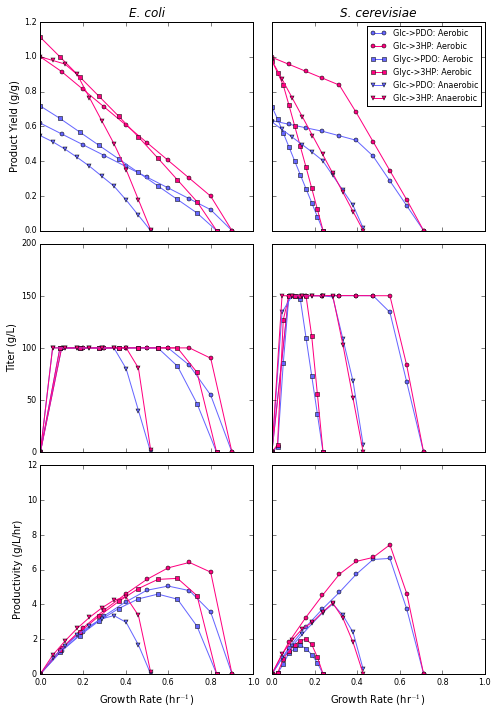

In [8]:
import matplotlib.pyplot as plt
import matplotlib

from cbmTES.global_constants import *

import cPickle as pickle

performances = pickle.load(open('jar/performances_gram.pickle', 'rb'))

fig = plt.figure(1, figsize = (7, 10))
plt.hold(True)
legend=[]
lines=()

for key, performance in performances.items():
    
    growth_rate = [p['growth_rate'] for p in performance]
    product_yield = [p['product_yield'] for p in performance]
    productivity = [p['productivity'] for p in performance]
    product_titer = [p['product_titer'] for p in performance]
    biomass_yield = [p['biomass_yield'] for p in performance]
                     
    # hot fix productivity divide by zero error
        # only occurs at zero growth strains.  not important in higher scale evaluation because it is eliminated
    for _k, _p in enumerate(productivity):
        if _p == float('inf'):
            productivity[_k] = 0

    
    # setting line color, line type, marker, and legend
    
    if key[2] == r_glc:
        substrate = 'Glc'
        if key[1] == AEROBIC:  
            marker = 'o'
            condition = 'Aerobic'
        elif key[1] == ANAEROBIC:
            marker = 'v'
            condition = 'Anaerobic'
    else:
        marker = 's'
        substrate = 'Glyc'
        condition = 'Aerobic'
       
    if key[3] == r_3HPP:
        line_color = '#ff0080'
        
        product = '3HP'
    elif key[3] == r_13PDO:
        line_color = '#6666ff'
        product = 'PDO'
    
    if key[0] == 'ecoli':
        
        ax = plt.subplot(321)
        plt.title('E. coli',{'fontstyle':'italic'})
        plt.plot(growth_rate, product_yield, color=line_color, linestyle='-', marker=marker, markersize = 4)
        plt.ylabel('Product Yield (g/g)')
        plt.tick_params(labelbottom='off')
        plt.xlim([0, 1])
        plt.ylim([0, 1.2])
            
        ax = plt.subplot(323)
        plt.plot(growth_rate, product_titer, color=line_color, linestyle='-', marker=marker, markersize = 4)
        plt.ylabel('Titer (g/L)')
        plt.tick_params(labelsize=5)        
        plt.tick_params(labelbottom='off') 
        plt.xlim([0, 1])
        plt.ylim([0, 200])
        
        ax = plt.subplot(325)
        plt.plot(growth_rate, productivity, color=line_color, linestyle='-', marker=marker, markersize = 4)
        plt.ylabel('Productivity (g/L/hr)')
        plt.xlabel(r'Growth Rate (hr$^{-1}$)')
        plt.xlim([0, 1])
        plt.ylim([0, 12])
        
    else:
        ax = plt.subplot(322)
        plt.title('S. cerevisiae',{'fontstyle':'italic'})
        plt.plot(growth_rate, product_yield, color=line_color, linestyle='-', marker=marker, markersize = 4)
        plt.tick_params(labelleft='off',labelbottom='off') 
        plt.xlim([0, 1])
        plt.ylim([0, 1.2])
        
        ax = plt.subplot(324)
        plt.plot(growth_rate, product_titer, color=line_color, linestyle='-', marker=marker, markersize = 4)
        plt.tick_params(labelleft='off',labelbottom='off') 
        plt.xlim([0, 1])
        plt.ylim([0, 200])
        
        ax = plt.subplot(326)
        line = tuple(plt.plot(growth_rate, productivity, color=line_color, linestyle='-', marker=marker, markersize = 4))
        plt.tick_params(labelleft='off') 
        plt.xlabel(r'Growth Rate (hr$^{-1}$)')
        plt.xlim([0, 1])
        plt.ylim([0, 12])
        
        lines = lines + line
        legend.append(substrate+'->'+product+': '+condition)

# set figure properties
for i in [1,2,3,4,5,6]:
    ax = plt.subplot(3,2,i)
    ax.xaxis.label.set_fontsize(10)
    ax.yaxis.label.set_fontsize(10)
    ax.tick_params(labelsize=8)
plt.tight_layout(w_pad=0.7,h_pad=0.5)

plt.subplot(3,2,2)
plt.legend(legend, fontsize=8)
#plt.legend(legend, loc='center', ncol=3, fontsize=5, handlelength=5,bbox_to_anchor=[0, -0.2])
#fig.legend(lines, tuple(legend), 'lower right', mode='expand', ncol=2, fontsize=4, handlelength=5,  bbox_to_anchor=[0.5, -0.05])
plt.savefig('figures/tradeoff_YTP.png', dpi=300)
plt.savefig('figures/tradeoff_YTP.svg')

In [ ]:

import cPickle as pickle

In [ ]:
strains = pickle.load(open('jar/strains.pickle', 'rb'))

In [ ]:
s = strains['scere', 0, 'R_EX_glc_e', 'R_EX_13PDO_e']

In [ ]:
for st in s:
    print st.fba_constraints

In [ ]:
    print st